# Lead Scoring Case Study

XEducation, an education company selling online courses, needs assistance in recognising and selecting promising leads that will most likely convert to paying customers. Our aim is to analyse and identify factors that help result in high customer conversion rate. This is done by assigning lead scores to each of the leads such that customers with high lead score indicate high chance of conversion 

Below Mentioned are the steps performed for the analysis:
1. Importing the Dataset
2. Inspecting the DataFrame
3. Missing Value Treatment
4. Data Preparation
5. Univariate Analysis
6. Outlier Treatment
7. Creating Dummy Variables
8. Train - Test Split
9. Feature Scaling
10. Model Building
11. Feature Selection Using RFE
12. Plotting the ROC Curve
13. Finding Optimal Cut-Off Points
14. Precision and Recall
15. Making Predictions on the Test Set
16. Assigning the Lead Score to the Data

In [1]:
# Supressing the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

# Styling the plot
style.use('ggplot')
sns.set_style('whitegrid')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score

In [3]:
# Adjusting Output Views
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

### Step 1: Importing the Dataset

In [4]:
# Importing the dataset
leads = pd.read_csv('Leads.csv')
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


### Step 2: Inspecting the DataFrame

In [5]:
# Shape
leads.shape

(9240, 37)

In [6]:
# Null Value and Data Type Information
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [7]:
# Checking Duplicate Values in 'Prospect ID'
sum(leads.duplicated(subset = 'Prospect ID')) == 0

True

In [8]:
# Duplicate Values in 'Lead Number'
sum(leads.duplicated(subset = 'Lead Number')) == 0

True

`Inference:` There are no duplicates in both 'Prospect ID' and 'Lead Number'

In [9]:
# Using this for Lead Score at the end of the notebook
Lead_Number = leads['Lead Number']

In [10]:
# Droppping these columns as we don't fit these in the model
cols_to_drop = ['Prospect ID', 'Lead Number']

### Step 3: Missing Value Treatment

In [11]:
# Replacing the 'Select' with NA values
leads = leads.replace('Select', np.nan)

In [12]:
# Missing Values Percentages
round((leads.isnull().sum()/len(leads)*100), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

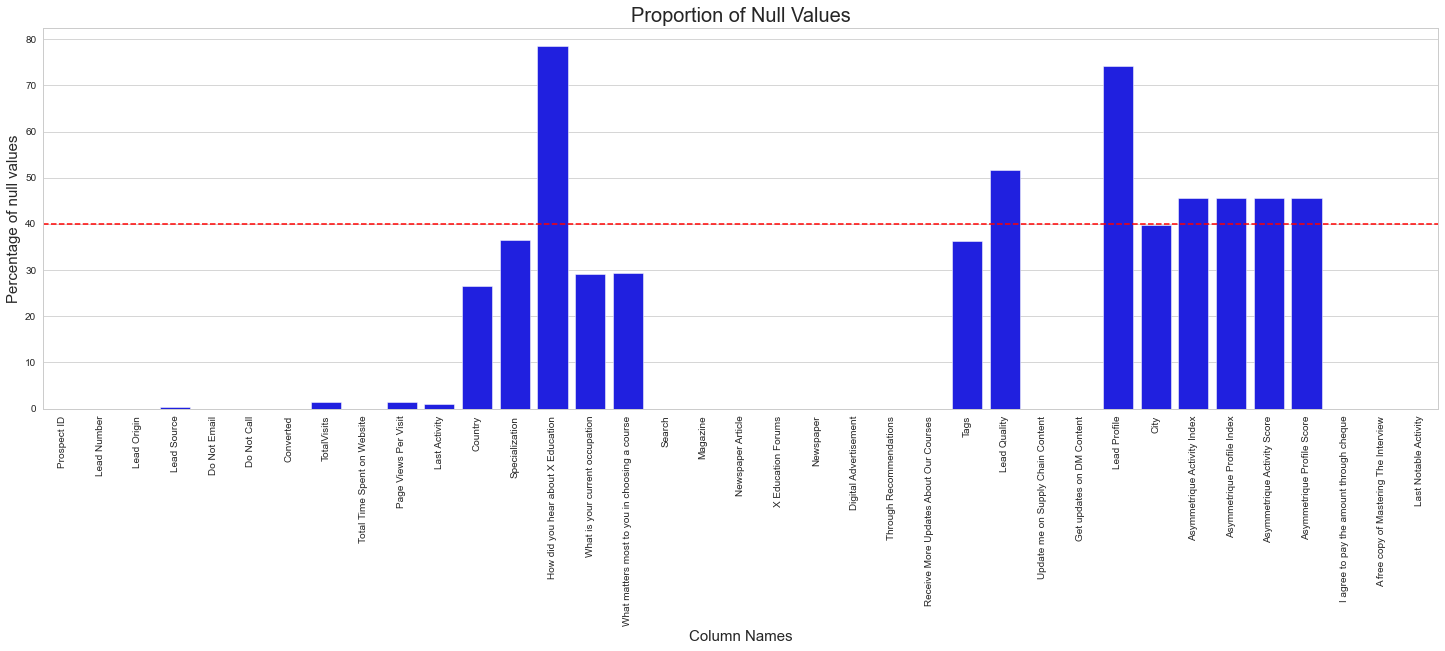

In [13]:
# Let us plot a bar graph to look at the proportion of null values with a benchmark of 40%
plt.figure(figsize = [25,7])
plt.title("Proportion of Null Values",fontsize=20)
plt.xlabel("Column Names", fontsize=15)
plt.ylabel("Percentage of null values", fontsize= 15)
plt.xticks(rotation=90)
ax = sns.barplot(leads.columns,round((leads.isnull().sum()/leads.shape[0])*100,2), color = 'blue')
ax.axhline(40, ls='--',color='red')
plt.show()

In [14]:
# Removing the missing values with more than 40%
cols = leads.columns

for i in cols:
    if((100*leads[i].isnull().sum()/len(leads.index)) >= 40):
        leads.drop(i, axis = 1, inplace = True)

In [15]:
# Missing Value Percentages for the remaining variables
round((leads.isnull().sum()/len(leads)*100), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Educatio

### Step 4: Data Preparation

#### Analyzing the Variables one-by-one

In [16]:
# City
leads['City'].value_counts(dropna = False)

NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

In [17]:
# Dropping the City column as most entries are Mumbai or not known. So, it won't help much in our analysis
cols_to_drop.append('City')

In [18]:
# Specialization
leads['Specialization'].value_counts(dropna= False)

NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

In [19]:
leads['Specialization'] = leads['Specialization'].replace(np.nan, 'Not Specified')

In [20]:
# Grouping values with low count in order to remove bias
# Management Specialization
leads['Specialization'] = leads['Specialization'].replace(['Finance Management', 'Human Resource Management',
                                                          'Marketing Management', 'Operations Management',
                                                          'IT Projects Management', 'Supply Chain Management',
                                                          'Healthcare Management', 'Hospitality Management',
                                                          'Retail Management'], 'Management Specializations')
# Business Specialization
leads['Specialization'] = leads['Specialization'].replace(['International Business', 'Rural and Agribusiness',
                                                          'E-Business'], 'Business Specializations')

In [21]:
# 'Tags'
leads['Tags'].value_counts(dropna = False)

NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with 

In [22]:
# Grouping values with low count in order to remove bias
leads['Tags'] = leads['Tags'].replace(np.nan, 'Not Specified')
leads['Tags'] = leads['Tags'].replace(['Recognition issue (DEC approval)', 'Shall take in the next coming month', 
                                      'University not recognized', 'Lateral student',
                                       'In confusion whether part time or DLP', 'Interested in Next batch, Still Thinking',
                                       'Want to take admission but has financial problems', 'Lost to Others',
                                      'in touch with EINS', 'number not provided', 'opp hangup', 'wrong number given',
                                      'Diploma holder (Not Eligible)', 'invalid number', 'Graduation in progress',
                                      'Interested  in full time MBA', 'Not doing further education', 'Lost to EINS', 'Busy',
                                      'switched off'], 'Other Tags')

In [23]:
# 'What matters most to you in choosing a course'
leads['What matters most to you in choosing a course'].value_counts(dropna = False)

Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [24]:
# Dropping 'What matters most to you in choosing a course' due to the presence of high Null Values and majority of the 
# them being Better Career Prospects
cols_to_drop.append('What matters most to you in choosing a course')

In [25]:
# 'What is your current occupation'
leads['What is your current occupation'].value_counts(dropna = False)

Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [26]:
# Grouping values with low count in order to remove bias
leads['What is your current occupation'] = leads['What is your current occupation'].replace(np.nan, 'Not Specified')
leads['What is your current occupation'] = leads['What is your current occupation'].replace(['Housewife', 'Businessman'],
                                                                                           'Other')

In [27]:
# 'Country'
leads['Country'].value_counts(dropna = False)

India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switzerland   

In [28]:
# Dropping Country column since, more than 90% values are India or NA only
cols_to_drop.append('Country')

In [29]:
# Lead Source
leads['Lead Source'].value_counts(dropna= False)

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

In [30]:
# Replacing the NULL Values in 'Lead Source' with Google and grouping values with low count in order to remove bias
leads['Lead Source'] = leads['Lead Source'].replace([np.nan, 'google'], 'Google')
leads['Lead Source'] = leads['Lead Source'].replace(['Referral Sites', 'Facebook', 'bing', 'google', 'Click2call',
                                                     'Live Chat', 'Social Media', 'Press_Release', 'testone',
                                                     'Pay per Click Ads', 'WeLearn', 'blog', 'welearnblog_Home',
                                                     'NC_EDM', 'youtubechannel'], 'Others')

In [31]:
# Last Activity
leads['Last Activity'].value_counts(dropna = False)

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
NaN                              103
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: Last Activity, dtype: int64

In [32]:
# Replacing the NA values and other less occuring entries as Others
leads['Last Activity'] = leads['Last Activity'].replace(np.nan, 'Email Opened')
leads['Last Activity'] = leads['Last Activity'].replace(['Visited Booth in Tradeshow', 'Resubscribed to emails',
                                                        'Email Marked Spam', 'Email Received',
                                                         'View in browser link Clicked', 'Approached upfront',
                                                         'Had a Phone Conversation', 'Unsubscribed', 'Unreachable'],
                                                        'Others')

In [33]:
# 'TotalVisits'
leads['TotalVisits'].describe()

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

In [34]:
# Replacing Null Values in 'TotalVisits' with median
leads['TotalVisits'] = leads['TotalVisits'].replace(np.nan, leads['TotalVisits'].median())

In [35]:
# 'Page Views Per Visit'
leads['Page Views Per Visit'].describe()

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

In [36]:
# Replacing the Null Values with 0.0, since, this is the most common entry
leads['Page Views Per Visit'] = leads['Page Views Per Visit'].replace(np.nan, leads['Page Views Per Visit'].median())

In [37]:
leads['Do Not Call'].value_counts()

No     9238
Yes       2
Name: Do Not Call, dtype: int64

In [38]:
leads['Search'].value_counts()

No     9226
Yes      14
Name: Search, dtype: int64

In [39]:
leads['Magazine'].value_counts()

No    9240
Name: Magazine, dtype: int64

In [40]:
leads['Newspaper Article'].value_counts()

No     9238
Yes       2
Name: Newspaper Article, dtype: int64

In [41]:
leads['Receive More Updates About Our Courses'].value_counts()

No    9240
Name: Receive More Updates About Our Courses, dtype: int64

In [42]:
leads['X Education Forums'].value_counts()

No     9239
Yes       1
Name: X Education Forums, dtype: int64

In [43]:
leads['Newspaper'].value_counts()

No     9239
Yes       1
Name: Newspaper, dtype: int64

In [44]:
leads['Digital Advertisement'].value_counts()

No     9236
Yes       4
Name: Digital Advertisement, dtype: int64

In [45]:
leads['Through Recommendations'].value_counts()

No     9233
Yes       7
Name: Through Recommendations, dtype: int64

In [46]:
leads['Receive More Updates About Our Courses'].value_counts()

No    9240
Name: Receive More Updates About Our Courses, dtype: int64

In [47]:
leads['Update me on Supply Chain Content'].value_counts()

No    9240
Name: Update me on Supply Chain Content, dtype: int64

In [48]:
leads['Get updates on DM Content'].value_counts()

No    9240
Name: Get updates on DM Content, dtype: int64

In [49]:
leads['I agree to pay the amount through cheque'].value_counts()

No    9240
Name: I agree to pay the amount through cheque, dtype: int64

In [50]:
# Adding the redundant columns to cols_to_drop in order to drop them
cols_to_drop.extend(['Do Not Call', 'Search', 'Magazine', 'Newspaper Article',
                     'Receive More Updates About Our Courses', 'X Education Forums', 'Newspaper', 'Digital Advertisement',
                     'Through Recommendations', 'Receive More Updates About Our Courses',
                     'Update me on Supply Chain Content', 'Get updates on DM Content',
                     'I agree to pay the amount through cheque'])

In [51]:
# Dropping the Variables
leads = leads.drop(cols_to_drop, axis = 1)

In [52]:
# Checking the info again
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9240 non-null   object 
 1   Lead Source                             9240 non-null   object 
 2   Do Not Email                            9240 non-null   object 
 3   Converted                               9240 non-null   int64  
 4   TotalVisits                             9240 non-null   float64
 5   Total Time Spent on Website             9240 non-null   int64  
 6   Page Views Per Visit                    9240 non-null   float64
 7   Last Activity                           9240 non-null   object 
 8   Specialization                          9240 non-null   object 
 9   What is your current occupation         9240 non-null   object 
 10  Tags                                    9240 non-null   obje

### Step 5: Univariate Analysis

#### Categorical Variables

In [53]:
def cat_var(cat):
    plt.figure(figsize=(15, 5))
    ax = sns.countplot(x = cat, hue = leads.Converted, data=leads)
    
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center')
    
    plt.xticks(rotation = 90)
    plt.show()

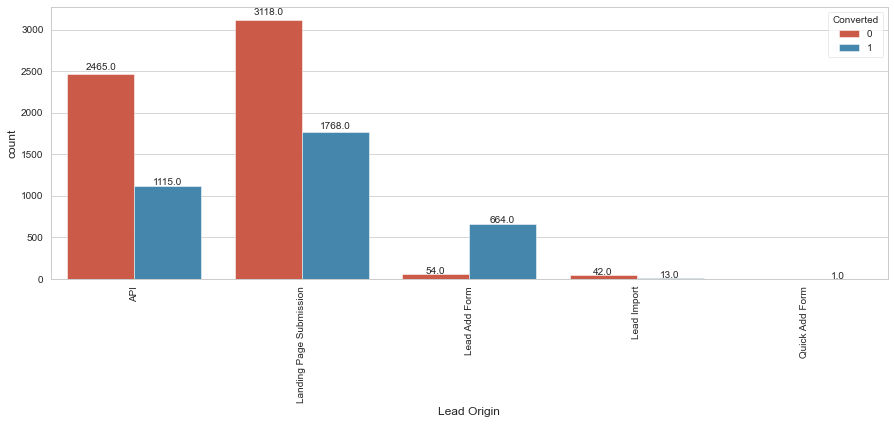

In [54]:
cat_var('Lead Origin')

`Inference:`
1. Customers identified via Lead Add Form have a high conversion of 664.

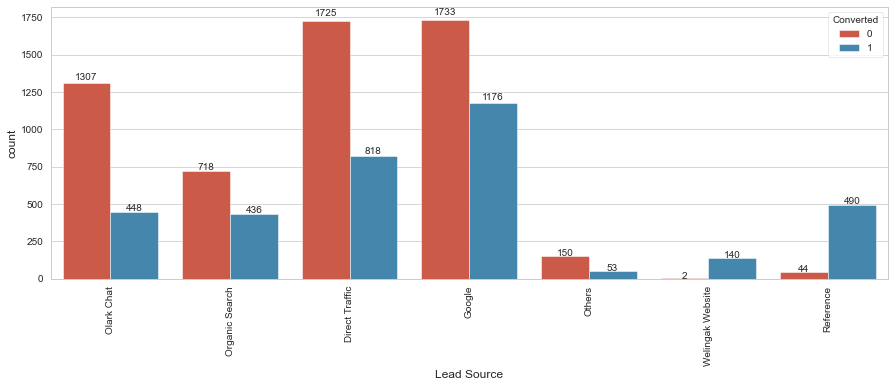

In [55]:
cat_var('Lead Source')

`Inference:`
1. Source of Lead via Google and Direct Traffic have high negative conversion as compared to others.
2. Leads coming via Reference have the highest conversion rate.

In [56]:
leads['Last Activity'] = leads['Last Activity'].replace(['Unreachable', 'Unsubscribed', 'Had a Phone Conversation',
                                                        'View in browser link Clicked', 'Approached upfront',
                                                        'Visited Booth in Tradeshow', 'Resubscribed to emails',
                                                        'Email Received', 'Email Marked Spam',
                                                        'Form Submitted on Website'], 'Other Methods')
leads['Last Activity'] = leads['Last Activity'].replace('Others', 'Other Methods')

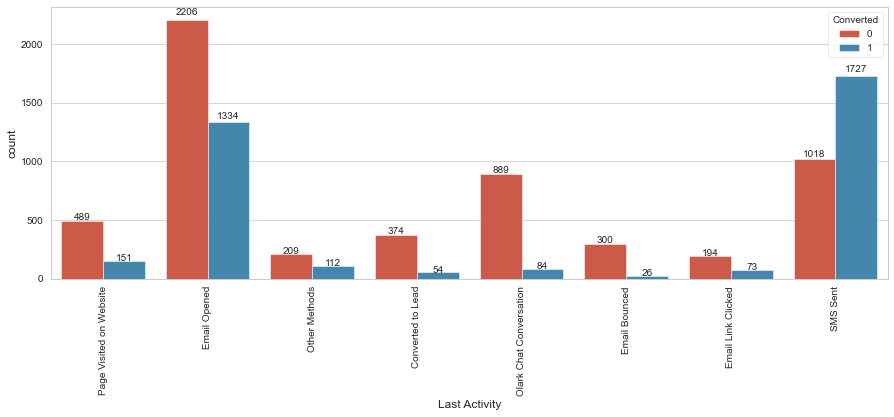

In [57]:
cat_var('Last Activity')

`Inference:`
1. Last Activity performed by Customers is SMS sent, then it has conversion of 1727.

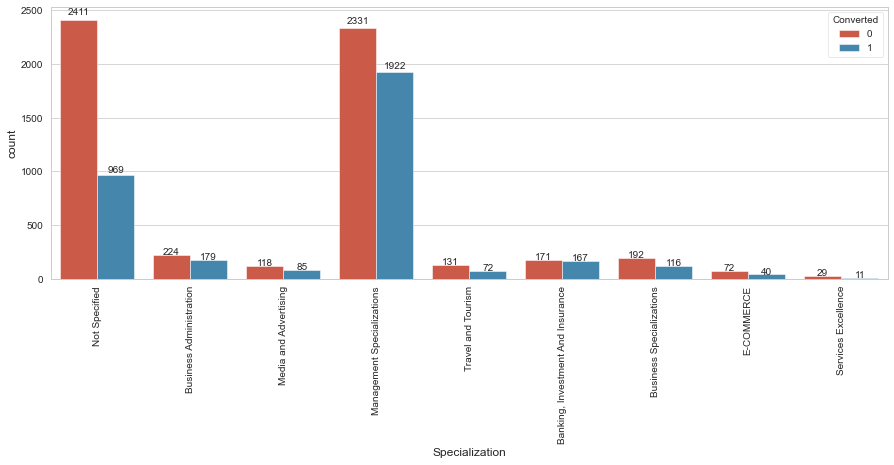

In [58]:
cat_var('Specialization')

`Inference:`
1. Customers who worked in Management Specialization have conversion of 1922.
2. Customers who worked in Service have the least conversion.

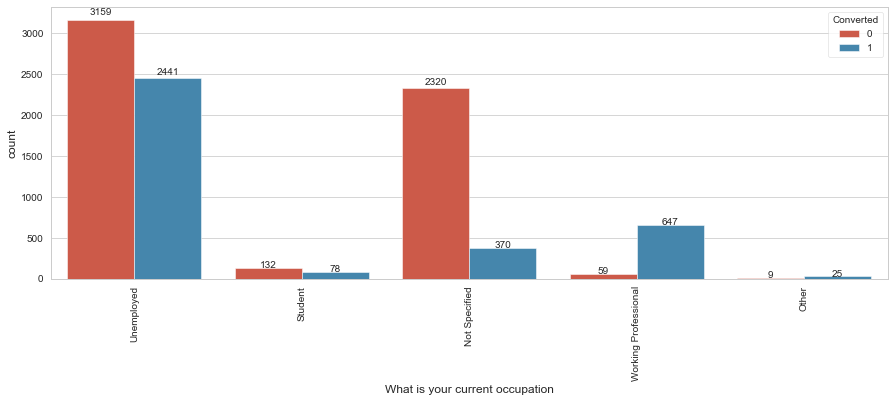

In [59]:
cat_var('What is your current occupation')

`Inference:`
1. It is interesting to know that out of 5600, only 2441 converted.
2. From 706 Working Professionals, 647 converted.

In [60]:
# Grouping values with low count in order to remove bias
leads['Last Notable Activity'] = leads['Last Notable Activity'].replace(['Email Bounced', 'Email Link Clicked',
                                                                         'Unreachable', 'Had a Phone Conversation',
                                                                        'Olark Chat Conversation', 'Approached upfront',
                                                                        'Resubscribed to emails', 'Unsubscribed',
                                                                         'View in browser link Clicked',
                                                                        'Form Submitted on Website', 'Email Received',
                                                                         'Email Marked Spam'], 'Others')

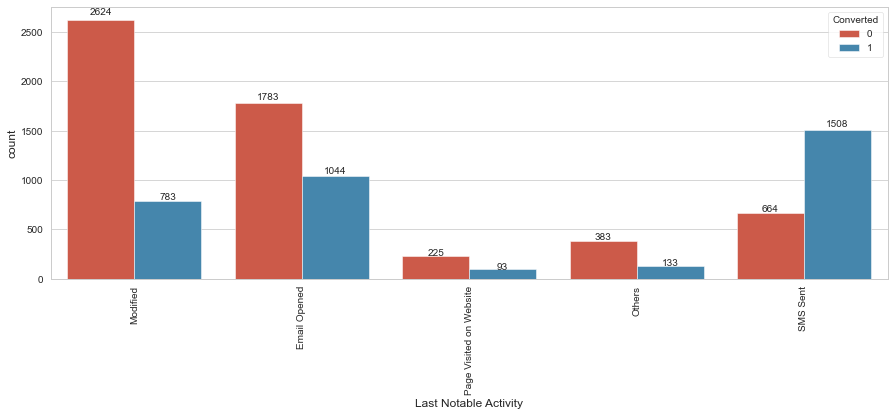

In [61]:
cat_var('Last Notable Activity')

`Inference:`
1. For individuals with Last Notable activity as SMS sent, 1508 people converted.

In [62]:
# Checking the Percentages of Converted Values
sum(leads['Converted'])/len(leads['Converted'])*100

38.53896103896104

`Inference:` There are 38.5% Converted Leads

#### Numerical Variables

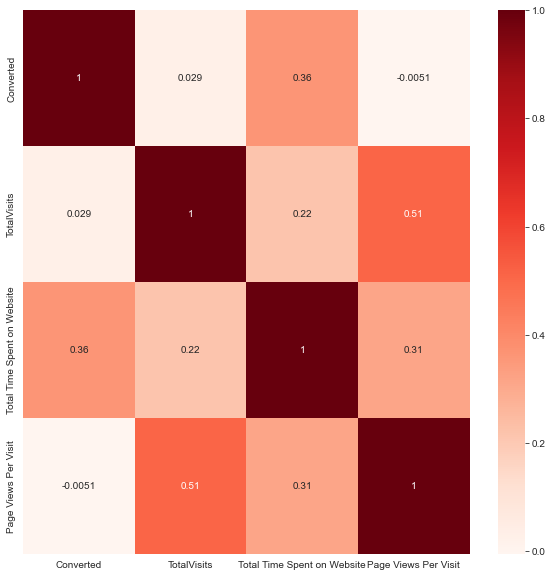

In [63]:
# Checking the Numberical columns for Corelation
plt.figure(figsize = (10,10))
sns.heatmap(leads.corr(), annot = True, cmap= 'Reds')
plt.show()

### Step 6: Outlier Treatment

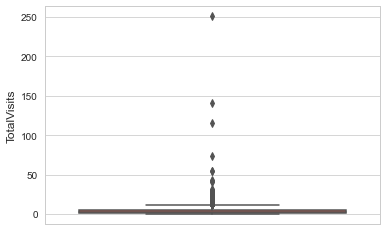

In [64]:
# 'TotalVisits'
sns.boxplot(y= leads['TotalVisits'])
plt.show()

In [65]:
leads['TotalVisits'].describe(percentiles = [0.05, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count    9240.000000
mean        3.438636
std         4.819024
min         0.000000
5%          0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

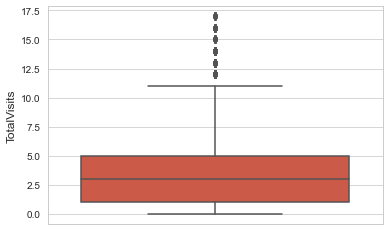

In [66]:
# Removing the top 1% of the value to handle outliers
leads = leads[(leads['TotalVisits'] <= leads['TotalVisits'].quantile(0.99))]
sns.boxplot(y = leads['TotalVisits'])
plt.show()

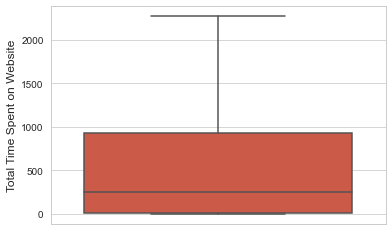

In [67]:
# 'Total Time Spent on Website'
sns.boxplot(y = leads['Total Time Spent on Website'])
plt.show()

In [68]:
# 'Page Views Per Visit'
leads['Page Views Per Visit'].describe(percentiles = [0.05, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count    9157.000000
mean        2.332225
std         2.047285
min         0.000000
5%          0.000000
25%         1.000000
50%         2.000000
75%         3.000000
90%         5.000000
95%         6.000000
99%         9.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64

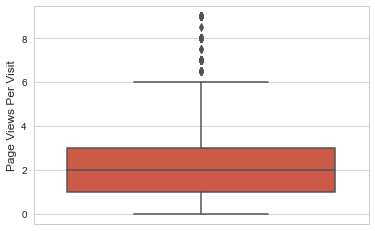

In [69]:
# Removing the top 1% of the values to handle the outliers
leads = leads[(leads['Page Views Per Visit'] <= leads['Page Views Per Visit'].quantile(0.99))]
sns.boxplot(y = leads['Page Views Per Visit'])
plt.show()

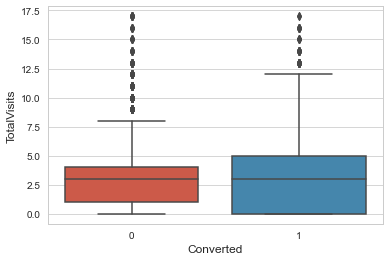

In [70]:
# Checking 'TotalVisits' vs 'Converted'
sns.boxplot(x = leads['Converted'], y = leads['TotalVisits'])
plt.show()

`Inference:` Median of both Converted and Not Converted for 'TotalVisits' is almost same.

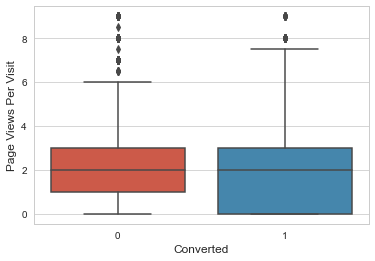

In [71]:
# Checking 'Page Views Per Visit' vs 'Converted'
sns.boxplot(x = leads['Converted'], y = leads['Page Views Per Visit'])
plt.show()

`Inference:` Median of both Converted and Not Converted for 'Page Views Per Visit' is almost same.

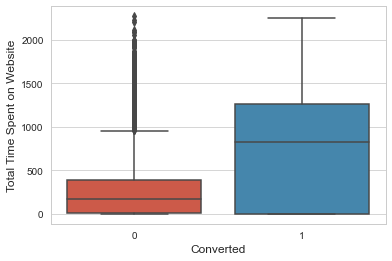

In [72]:
# Checking 'Page Views Per Visit' vs 'Converted'
sns.boxplot(x = leads['Converted'], y = leads['Total Time Spent on Website'])
plt.show()

`Inference:` Leads spending more time on the website tend to be converted.

In [73]:
# Converting Yes/No into 1/0 to fit the model
def binary_map(x):
    return x.map({'Yes': 1, 'No':0})

varlist = ['Do Not Email', 'A free copy of Mastering The Interview']

# Applying the above custom function

leads[varlist] = leads[varlist].apply(binary_map)

In [74]:
leads.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Not Specified,Unemployed,Interested in other courses,0,Modified
1,API,Organic Search,0,0,5.0,674,2.5,Email Opened,Not Specified,Unemployed,Ringing,0,Email Opened
2,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,1,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Other Methods,Media and Advertising,Unemployed,Ringing,0,Modified
4,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,Not Specified,Unemployed,Will revert after reading the email,0,Modified


### Step 7: Creating Dummy Variables

In [75]:
cat_cols = leads.select_dtypes(include = 'object').columns
cat_cols

Index(['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization', 'What is your current occupation', 'Tags', 'Last Notable Activity'], dtype='object')

In [76]:
# Lead Origin
Lead_Origin = pd.get_dummies(leads['Lead Origin'], prefix = 'Lead_Origin')
Lead_Origin = Lead_Origin.drop('Lead_Origin_Quick Add Form', axis = 1)
leads = pd.concat([leads, Lead_Origin], axis = 1)

In [77]:
# Lead Source
Lead_Source = pd.get_dummies(leads['Lead Source'], prefix = 'Lead_Source')
Lead_Source = Lead_Source.drop('Lead_Source_Others', axis = 1)
leads = pd.concat([leads, Lead_Source], axis = 1)

In [78]:
# Last Activity
Last_Activity = pd.get_dummies(leads['Last Activity'], prefix = 'Last_Activity')
Last_Activity = Last_Activity.drop('Last_Activity_Other Methods', axis = 1)
leads = pd.concat([leads, Last_Activity], axis = 1)

In [79]:
# Specialization
Special = pd.get_dummies(leads['Specialization'], prefix = 'Specialization')
Special = Special.drop('Specialization_Not Specified', axis = 1)
leads = pd.concat([leads, Special], axis = 1)

In [80]:
# What is your current occupation
occup = pd.get_dummies(leads['What is your current occupation'], prefix = 'Occupation')
occup = occup.drop('Occupation_Other', axis = 1)
leads = pd.concat([leads, occup], axis = 1)

In [81]:
# Tags
tags = pd.get_dummies(leads['Tags'], prefix = 'Tags')
tags = tags.drop('Tags_Not Specified', axis = 1)
leads = pd.concat([leads, tags], axis = 1)

In [82]:
# Last Notable Activity
act = pd.get_dummies(leads['Last Notable Activity'], prefix = 'Last_Notable_Activity')
act = act.drop('Last_Notable_Activity_Others', axis = 1)
leads = pd.concat([leads, act], axis = 1)

In [83]:
leads.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,A free copy of Mastering The Interview,Last Notable Activity,Lead_Origin_API,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Lead_Source_Direct Traffic,Lead_Source_Google,Lead_Source_Olark Chat,Lead_Source_Organic Search,Lead_Source_Reference,Lead_Source_Welingak Website,Last_Activity_Converted to Lead,Last_Activity_Email Bounced,Last_Activity_Email Link Clicked,Last_Activity_Email Opened,Last_Activity_Olark Chat Conversation,Last_Activity_Page Visited on Website,Last_Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Business Specializations,Specialization_E-COMMERCE,Specialization_Management Specializations,Specialization_Media and Advertising,Specialization_Services Excellence,Specialization_Travel and Tourism,Occupation_Not Specified,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Still Thinking,Tags_Will revert after reading the email,Last_Notable_Activity_Email Opened,Last_Notable_Activity_Modified,Last_Notable_Activity_Page Visited on Website,Last_Notable_Activity_SMS Sent
0,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Not Specified,Unemployed,Interested in other courses,0,Modified,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
1,API,Organic Search,0,0,5.0,674,2.5,Email Opened,Not Specified,Unemployed,Ringing,0,Email Opened,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,1,Email Opened,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Other Methods,Media and Advertising,Unemployed,Ringing,0,Modified,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,Not Specified,Unemployed,Will revert after reading the email,0,Modified,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0


#### Dropping the Repeated Variables

In [84]:
leads = leads.drop(cat_cols, axis = 1)

In [85]:
leads.head()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead_Origin_API,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Lead_Source_Direct Traffic,Lead_Source_Google,Lead_Source_Olark Chat,Lead_Source_Organic Search,Lead_Source_Reference,Lead_Source_Welingak Website,Last_Activity_Converted to Lead,Last_Activity_Email Bounced,Last_Activity_Email Link Clicked,Last_Activity_Email Opened,Last_Activity_Olark Chat Conversation,Last_Activity_Page Visited on Website,Last_Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Business Specializations,Specialization_E-COMMERCE,Specialization_Management Specializations,Specialization_Media and Advertising,Specialization_Services Excellence,Specialization_Travel and Tourism,Occupation_Not Specified,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Still Thinking,Tags_Will revert after reading the email,Last_Notable_Activity_Email Opened,Last_Notable_Activity_Modified,Last_Notable_Activity_Page Visited on Website,Last_Notable_Activity_SMS Sent
0,0,0,0.0,0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0,0,5.0,674,2.5,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,0,1,2.0,1532,2.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,0,0,1.0,305,1.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,1,2.0,1428,1.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0


### Step 8: Train - Test Split

In [86]:
y = leads['Converted']

X = leads.drop('Converted', axis = 1)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.70, random_state= 100)

In [88]:
X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead_Origin_API,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Lead_Source_Direct Traffic,Lead_Source_Google,Lead_Source_Olark Chat,Lead_Source_Organic Search,Lead_Source_Reference,Lead_Source_Welingak Website,Last_Activity_Converted to Lead,Last_Activity_Email Bounced,Last_Activity_Email Link Clicked,Last_Activity_Email Opened,Last_Activity_Olark Chat Conversation,Last_Activity_Page Visited on Website,Last_Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Business Specializations,Specialization_E-COMMERCE,Specialization_Management Specializations,Specialization_Media and Advertising,Specialization_Services Excellence,Specialization_Travel and Tourism,Occupation_Not Specified,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Still Thinking,Tags_Will revert after reading the email,Last_Notable_Activity_Email Opened,Last_Notable_Activity_Modified,Last_Notable_Activity_Page Visited on Website,Last_Notable_Activity_SMS Sent
302,0,7.0,250,2.33,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6087,1,0.0,0,0.00,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1033,0,5.0,470,5.00,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
7656,1,6.0,352,6.00,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3241,0,4.0,973,1.33,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


### Step 9: Feature Scaling

In [89]:
# Scaling the Numerical variables
scaler = StandardScaler()

num_cols = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead_Origin_API,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Lead_Source_Direct Traffic,Lead_Source_Google,Lead_Source_Olark Chat,Lead_Source_Organic Search,Lead_Source_Reference,Lead_Source_Welingak Website,Last_Activity_Converted to Lead,Last_Activity_Email Bounced,Last_Activity_Email Link Clicked,Last_Activity_Email Opened,Last_Activity_Olark Chat Conversation,Last_Activity_Page Visited on Website,Last_Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Business Specializations,Specialization_E-COMMERCE,Specialization_Management Specializations,Specialization_Media and Advertising,Specialization_Services Excellence,Specialization_Travel and Tourism,Occupation_Not Specified,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Still Thinking,Tags_Will revert after reading the email,Last_Notable_Activity_Email Opened,Last_Notable_Activity_Modified,Last_Notable_Activity_Page Visited on Website,Last_Notable_Activity_SMS Sent
302,0,1.336782,-0.428736,0.044021,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6087,1,-1.094877,-0.887355,-1.206716,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1033,0,0.642022,-0.025151,1.477269,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
7656,1,0.989402,-0.241619,2.014065,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3241,0,0.294642,0.897591,-0.492776,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


### Step 10: Model Building

##### First Model

In [90]:
# Model 1
# Model building using statsmodels

# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6316
Model Family:                Binomial   Df Model:                           46
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1401.9
Date:                Mon, 23 Jan 2023   Deviance:                       2803.8
Time:                        11:47:33   Pearson chi2:                 7.75e+03
No. Iterations:                    20   Pseudo R-squ. (CS):             0.5889
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               21.3615   2.92e+04      0.001      0.999   -5.73e+04    5.73e+04
Do Not Email                                        -1.2419      0.259     -4.788      0.000      -1.750      -0.734
TotalVisits                                          0.2459      0.074      3.317      0.001       0.101       0.391
Total Time Spent on Website                          1.0836      0.057     18.947      0.000       0.972       1.196
Page Views Per Visit                                -0.3118      0.085     -3.654      0.000      -0.479      -0.145
A free copy of Mastering The Interview              -0.0511      0.159     -0.321      0.748      -0.363       0.261
Lead_Origin_API                                    -20.4355   2.92e+04     -0.001      0.999   -5.73e+04    5.73e+04
Lead_Origin_Landing Page Submission                -20.6439   2.92e+04     -0.001      0.999   -5.73e+04    5.73e+04
Lead_Origin_Lead Add Form                          -17.5829   2.92e+04     -0.001      1.000   -5.73e+04    5.73e+04
Lead_Origin_Lead Import                            -20.8889   2.92e+04     -0.001      0.999   -5.73e+04    5.73e+04
Lead_Source_Direct Traffic                          -0.1668      0.427     -0.391      0.696      -1.003       0.670
Lead_Source_Google                                  -0.1535      0.410     -0.375      0.708      -0.956       0.649
Lead_Source_Olark Chat                               0.7239      0.430      1.683      0.092      -0.119       1.567
Lead_Source_Organic Search                          -0.5613      0.427     -1.315      0.189      -1.398       0.275
Lead_Source_Reference                               -1.7695      1.091     -1.622      0.105      -3.908       0.369
Lead_Source_Welingak Website                         2.2402      1.451      1.544      0.123      -0.603       5.084
Last_Activity_Converted to Lead                     -0.7332      0.395     -1.856      0.064      -1.508       0.041
Last_Activity_Email Bounced                         -1.3537      0.567     -2.386      0.017      -2.466      -0.242
Last_Activity_Email Link Clicked                    -0.6089      0.427     -1.425      0.154      -1.446       0.228
Last_Activity_Email Opened                           0.0490      0.338      0.145      0.885      -0.613       0.711
Last_Activity_Olark Chat Conversation               -1.2844      0.347     -3.707      0.000      -1.964      -0.605
Last_Activity_Page Visited on Website               -1.0111      0.438     -2.310      0.021      -1.869      -0.153
Last_Activity_SMS Sent                               0.5489      0.331      1.660      0.097      -0.099       1.197
Specialization_Banking, Investment And In

### Step 11: Feature Selection Using RFE

In [92]:
# Logistic Regression
logreg = LogisticRegression()

rfe = RFE(logreg, 20)             
rfe = rfe.fit(X_train, y_train)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [ ]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [ ]:
# Selected Variables
col = X_train.columns[rfe.support_]
col

In [ ]:
X_train.columns[~rfe.support_]

#### Second Model
##### Accessing the model with statsmodels

In [ ]:
# Model 2
X_train_sm = sm.add_constant(X_train[col])

logm2 = sm.GLM(y_train, X_train_sm, family= sm.families.Binomial())
res = logm2.fit()
res.summary()

In [ ]:
# Dropping the variables with p-values greater than 0.05
col = col.drop(['Lead_Source_Reference', 'Lead_Source_Welingak Website'])
col

#### Third Model

In [ ]:
# Model 3
X_train_sm = sm.add_constant(X_train[col])

logm3 = sm.GLM(y_train, X_train_sm, family= sm.families.Binomial())
res = logm3.fit()
res.summary()

##### Checking VIFs

In [ ]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [ ]:
# Predictions on the train set
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred

##### Creating the DataFrame with Actual Converted and Predicted Probabilities

In [ ]:
y_train_pred_final = pd.DataFrame({'Converted': y_train.values, 'Converted_Prob': y_train_pred})
y_train_pred_final['Prospect ID'] = y_train.index
y_train_pred_final.head()

##### Creating a new column Predicted with 1 if Probability > 0.5

In [ ]:
# Making a new column Predicted with values which have Probability greater than 0.5
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

In [ ]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_true= y_train_pred_final.Converted, y_pred= y_train_pred_final.Predicted))

In [ ]:
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(y_true= y_train_pred_final.Converted, y_pred= y_train_pred_final.Predicted)
confusion

In [ ]:
# Actual/Predicted     Not_Converted    Converted
    # Not_Converted        3757            178
    # Converted            380             2048  

##### Metrics beyond Simple Accuracy

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

In [ ]:
# Let us calculate specificity
TN / float(TN+FP)

In [ ]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

In [ ]:
# positive predictive value 
print (TP / float(TP+FP))

In [ ]:
# Negative predictive value
print (TN / float(TN+ FN))

### Step 12: Plotting the ROC Curve

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob,
                                         drop_intermediate = False)

In [ ]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

### Step 13: Finding Optimal Cut-off Points

Optimal cutoff probability is that probability where we get balanced sensitivity and specificity.

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.show()

##### From the curve above, we can see that 0.3 is our Optimal Point

In [ ]:
y_train_pred_final['Final_Predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

In [ ]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_true= y_train_pred_final.Converted, y_pred= y_train_pred_final.Final_Predicted))

In [ ]:
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(y_true= y_train_pred_final.Converted, y_pred= y_train_pred_final.Final_Predicted)
confusion

In [ ]:
# Actual/Predicted     Not_Converted    Converted
    # Not_Converted        3523            412
    # Converted            213             2215  

#### Metrics beyond Simple Accuracy with 0.3 as Optimal Cutoff point

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [ ]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

In [ ]:
# Let us calculate specificity
TN / float(TN+FP)

In [ ]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

In [ ]:
# Positive predictive value 
print (TP / float(TP+FP))

In [ ]:
# Negative predictive value
print (TN / float(TN+ FN))

### Step 14: Precision and Recall

In [ ]:
# Precision Score
precision_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted)

In [ ]:
# Recall Score
recall_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted)

#### Precision and Recall Tradeoff

In [ ]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

In [ ]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Step 15: Making Predictions on the Test Set

In [ ]:
# Scaling the Numerical Variables
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
X_test = X_test[col]
X_test.head()

In [ ]:
X_test_sm = sm.add_constant(X_test)

In [ ]:
# Predictions on test set
y_test_pred = res.predict(X_test_sm)
y_test_pred.head()

In [ ]:
# Converting y_pred to a DataFrame
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

In [ ]:
# Converting y_test to DataFrame
y_test_df = pd.DataFrame(y_test)

In [ ]:
# Putting 'Prospect ID' to index
y_test_df['Prospect ID'] = y_test_df.index

In [ ]:
# Removing index for both DataFrames to concatenate them side by side
y_pred_1.reset_index(drop= True, inplace= True)
y_test_df.reset_index(drop= True, inplace= True)

In [ ]:
# Concatenating y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1], axis = 1)
y_pred_final.head()

In [ ]:
# Renaming the column
y_pred_final = y_pred_final.rename(columns = {0: 'Converted_Prob'})

In [ ]:
# Rearranging the columns
y_pred_final = y_pred_final[['Prospect ID', 'Converted', 'Converted_Prob']]
y_pred_final.head()

In [ ]:
y_pred_final['Final_Predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.3 else 0)
y_pred_final.head()

In [ ]:
# Overall Accuracy
metrics.accuracy_score(y_true= y_pred_final.Converted, y_pred= y_pred_final.Final_Predicted)

In [ ]:
# Confusion Matrix
confusion2 = metrics.confusion_matrix(y_true= y_pred_final.Converted, y_pred= y_pred_final.Final_Predicted)
confusion2

In [ ]:
TP = confusion2[1,1]
TN = confusion2[0,0]
FP = confusion2[0,1]
FN = confusion2[1,0]

In [ ]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

In [ ]:
# Let us calculate specificity
TN / float(TN+FP)

In [ ]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

In [ ]:
# Positive predictive value 
print (TP / float(TP+FP))

In [ ]:
# Negative predictive value
print (TN / float(TN+ FN))

## Conclusions:
1. Variables found which contribute the most to the model are as follows:
    - Tags_Already a student
    - Tags_Ringing
    - Tags_Closed by Horizzon
    - Tags_Interested in other courses
    - Lead_Origin_Lead Add Form
    - Tags_Will revert after reading the email

### Step 16: Assigning the Lead Score to the data

In [ ]:
leads_score = leads
leads_score.head()

In [ ]:
# Scaling the numerical variables
leads_score[num_cols] = scaler.transform(leads_score[num_cols])

In [ ]:
# Removing all the variables which were not in our final model
leads_score = leads_score[col]
leads_score = sm.add_constant(leads_score)
leads_score.head()

In [ ]:
# Making predictions
leads_score_pred = res.predict(leads_score)
leads_score_pred.head()

In [ ]:
leads_score['Lead Score'] = round(leads_score_pred*100)
leads_score.head()

In [ ]:
# Adding Lead Number to see which Lead has scored how much
leads_score['Lead Number'] = Lead_Number
leads_score.head()

In [ ]:
# Plotting Boxplot to check the distribution for the Lead Scores calculated
sns.boxplot(y = leads_score['Lead Score'])
plt.show()